# Resnet-18 model create

In [9]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def ResNet18(show_layers=False, **kwargs):
    '''
    # classification_models 패키지 설치
    
    pip install git+https://github.com/qubvel/classification_models.git
    
    '''
    from classification_models.keras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(**kwargs)
    x = GlobalAveragePooling2D()(base_model.output)
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    model.compile(optimizer=SGD(lr=1e-2, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    if show_layers:
        for i, layer in enumerate(model.layers):
            print(i, layer.name, layer.trainable)
    
    return model

# Resnet-18 information

In [10]:
from keras.optimizers import SGD

model = ResNet18(input_shape=(224, 224, 3), weights=None, include_top=False)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

# create Resnet-18 model from Public DB

# CASIA-FASD

>>  1
=============================================ResNet-18==============================================
Found 21322 images belonging to 2 classes.
Found 6579 images belonging to 2 classes.
Epoch 1/100
1333/1333 [==============================] - 114s 86ms/step - loss: 0.0922 - acc: 0.9692 - val_loss: 0.0046 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00461, saving model to trained_model_public\CASIA-FASD\1\1-01-0.0046.hdf5
Epoch 2/100
1333/1333 [==============================] - 105s 79ms/step - loss: 0.0147 - acc: 0.9964 - val_loss: 0.0036 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00461 to 0.00361, saving model to trained_model_public\CASIA-FASD\1\1-02-0.0036.hdf5
Epoch 3/100
1333/1333 [==============================] - 106s 79ms/step - loss: 0.0079 - acc: 0.9986 - val_loss: 0.0010 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00361 to 0.00103, saving model to trained_model_public\CASIA-FASD\1\1-03-0.0010.hdf5
Epoch 4/100
1333/1333 [===

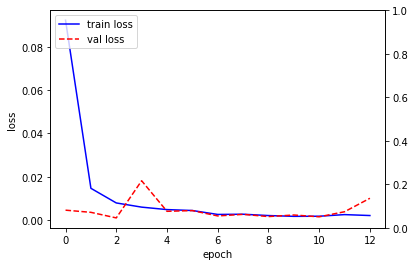

acc: 1.0000	loss: 0.0010
=============================================1 finished=============================================


In [22]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '1'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '1'
    
    saveDir = 'trained_model_public\\CASIA-FASD\\1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\CASIA-FASD\\CASIA-FASD-1', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  2
=============================================ResNet-18==============================================
Found 20692 images belonging to 2 classes.
Found 7208 images belonging to 2 classes.
Epoch 1/100
1294/1294 [==============================] - 113s 88ms/step - loss: 0.0817 - acc: 0.9748 - val_loss: 0.1301 - val_acc: 0.9351

Epoch 00001: val_loss improved from inf to 0.13014, saving model to trained_model_public\CASIA-FASD\2\2-01-0.1301.hdf5
Epoch 2/100
1294/1294 [==============================] - 105s 81ms/step - loss: 0.0133 - acc: 0.9972 - val_loss: 0.5820 - val_acc: 0.8556

Epoch 00002: val_loss did not improve from 0.13014
Epoch 3/100
1294/1294 [==============================] - 106s 82ms/step - loss: 0.0074 - acc: 0.9985 - val_loss: 0.4472 - val_acc: 0.8830

Epoch 00003: val_loss did not improve from 0.13014
Epoch 4/100
1294/1294 [==============================] - 105s 81ms/step - loss: 0.0041 - acc: 0.9996 - val_loss: 0.0888 - val_acc: 0.9526

Epoch 00004: val_loss improved 

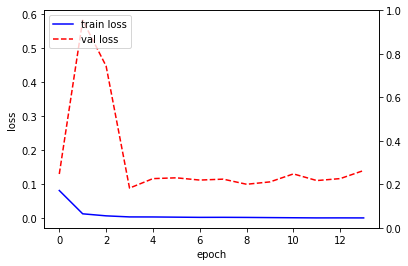

acc: 0.9526	loss: 0.0888
=============================================2 finished=============================================


In [23]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '2'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '2'
    
    saveDir = 'trained_model_public\\CASIA-FASD\\2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\CASIA-FASD\\CASIA-FASD-2', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  3
=============================================ResNet-18==============================================
Found 20952 images belonging to 2 classes.
Found 6950 images belonging to 2 classes.
Epoch 1/100
1310/1310 [==============================] - 117s 89ms/step - loss: 0.0923 - acc: 0.9680 - val_loss: 0.0465 - val_acc: 0.9868

Epoch 00001: val_loss improved from inf to 0.04649, saving model to trained_model_public\CASIA-FASD\3\3-01-0.0465.hdf5
Epoch 2/100
1310/1310 [==============================] - 103s 78ms/step - loss: 0.0137 - acc: 0.9975 - val_loss: 0.0175 - val_acc: 0.9958

Epoch 00002: val_loss improved from 0.04649 to 0.01746, saving model to trained_model_public\CASIA-FASD\3\3-02-0.0175.hdf5
Epoch 3/100
1310/1310 [==============================] - 103s 78ms/step - loss: 0.0091 - acc: 0.9979 - val_loss: 0.0412 - val_acc: 0.9896

Epoch 00003: val_loss did not improve from 0.01746
Epoch 4/100
1310/1310 [==============================] - 103s 79ms/step - loss: 0.0051 - acc: 0.99

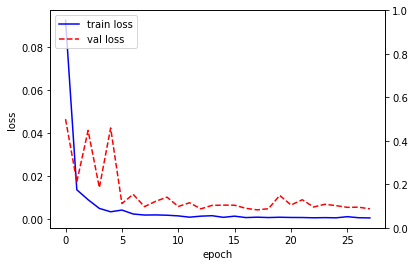

acc: 0.9996	loss: 0.0044
=============================================3 finished=============================================


In [5]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '3'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '3'
    
    saveDir = 'trained_model_public\\CASIA-FASD\\3'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\CASIA-FASD\\CASIA-FASD-3', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  4
=============================================ResNet-18==============================================
Found 20745 images belonging to 2 classes.
Found 7163 images belonging to 2 classes.
Epoch 1/100
1297/1297 [==============================] - 111s 86ms/step - loss: 0.0799 - acc: 0.9732 - val_loss: 0.8842 - val_acc: 0.8242

Epoch 00001: val_loss improved from inf to 0.88425, saving model to trained_model_public\CASIA-FASD\4\4-01-0.8842.hdf5
Epoch 2/100
1297/1297 [==============================] - 102s 79ms/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.4381 - val_acc: 0.9287

Epoch 00002: val_loss improved from 0.88425 to 0.43815, saving model to trained_model_public\CASIA-FASD\4\4-02-0.4381.hdf5
Epoch 3/100
1297/1297 [==============================] - 103s 80ms/step - loss: 0.0073 - acc: 0.9985 - val_loss: 1.0144 - val_acc: 0.8262

Epoch 00003: val_loss did not improve from 0.43815
Epoch 4/100
1297/1297 [==============================] - 103s 80ms/step - loss: 0.0038 - acc: 0.99

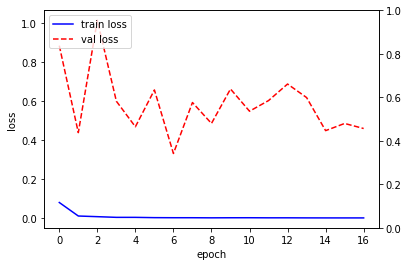

acc: 0.9284	loss: 0.3313
=============================================4 finished=============================================


In [6]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\CASIA-FASD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '4'
    
    saveDir = 'trained_model_public\\CASIA-FASD\\4'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\CASIA-FASD\\CASIA-FASD-4', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# MSU-MFSD

>>  1
=============================================ResNet-18==============================================
Found 26720 images belonging to 2 classes.
Found 6636 images belonging to 2 classes.
Epoch 1/100
1670/1670 [==============================] - 137s 82ms/step - loss: 0.0649 - acc: 0.9785 - val_loss: 0.1768 - val_acc: 0.9225

Epoch 00001: val_loss improved from inf to 0.17684, saving model to trained_model_public\MSU-MFSD\1\1-01-0.1768.hdf5
Epoch 2/100
1670/1670 [==============================] - 128s 77ms/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.0694 - val_acc: 0.9920

Epoch 00002: val_loss improved from 0.17684 to 0.06940, saving model to trained_model_public\MSU-MFSD\1\1-02-0.0694.hdf5
Epoch 3/100
1670/1670 [==============================] - 128s 77ms/step - loss: 0.0042 - acc: 0.9993 - val_loss: 0.2334 - val_acc: 0.9260

Epoch 00003: val_loss did not improve from 0.06940
Epoch 4/100
1670/1670 [==============================] - 128s 77ms/step - loss: 0.0026 - acc: 0.9997 -

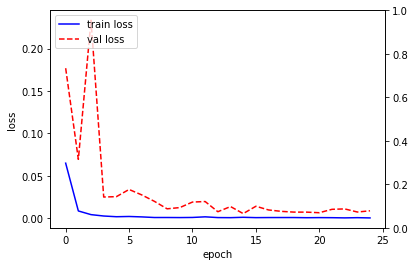

acc: 1.0000	loss: 0.0054
=============================================1 finished=============================================


In [7]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\MSU-MFSD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '1'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '1'
    
    saveDir = 'trained_model_public\\MSU-MFSD\\1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\MSU-MFSD\\MSU-MFSD-1', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  2
=============================================ResNet-18==============================================
Found 24403 images belonging to 2 classes.
Found 8953 images belonging to 2 classes.
Epoch 1/100
1526/1526 [==============================] - 131s 86ms/step - loss: 0.0680 - acc: 0.9761 - val_loss: 0.3010 - val_acc: 0.9305

Epoch 00001: val_loss improved from inf to 0.30103, saving model to trained_model_public\MSU-MFSD\2\2-01-0.3010.hdf5
Epoch 2/100
1526/1526 [==============================] - 120s 79ms/step - loss: 0.0062 - acc: 0.9991 - val_loss: 3.1089 - val_acc: 0.3884

Epoch 00002: val_loss did not improve from 0.30103
Epoch 3/100
1526/1526 [==============================] - 121s 79ms/step - loss: 0.0064 - acc: 0.9991 - val_loss: 0.1628 - val_acc: 0.9285

Epoch 00003: val_loss improved from 0.30103 to 0.16282, saving model to trained_model_public\MSU-MFSD\2\2-03-0.1628.hdf5
Epoch 4/100
1526/1526 [==============================] - 120s 79ms/step - loss: 0.0018 - acc: 0.9998 -

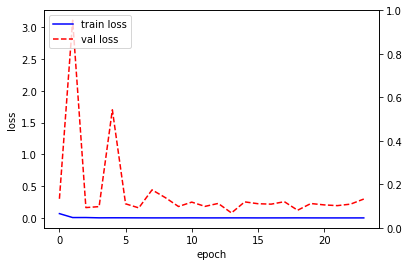

acc: 0.9669	loss: 0.0789
=============================================2 finished=============================================


In [11]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\MSU-MFSD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '2'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '2'
    
    saveDir = 'trained_model_public\\MSU-MFSD\\2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\MSU-MFSD\\MSU-MFSD-2', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  3
=============================================ResNet-18==============================================
Found 24513 images belonging to 2 classes.
Found 8843 images belonging to 2 classes.
Epoch 1/100
1533/1533 [==============================] - 134s 87ms/step - loss: 0.0752 - acc: 0.9744 - val_loss: 0.0018 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00178, saving model to trained_model_public\MSU-MFSD\3\3-01-0.0018.hdf5
Epoch 2/100
1533/1533 [==============================] - 123s 80ms/step - loss: 0.0078 - acc: 0.9987 - val_loss: 0.0015 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00178 to 0.00153, saving model to trained_model_public\MSU-MFSD\3\3-02-0.0015.hdf5
Epoch 3/100
1533/1533 [==============================] - 123s 80ms/step - loss: 0.0078 - acc: 0.9989 - val_loss: 0.0016 - val_acc: 1.0000

Epoch 00003: val_loss did not improve from 0.00153
Epoch 4/100
1533/1533 [==============================] - 124s 81ms/step - loss: 0.0063 - acc: 0.9990 -

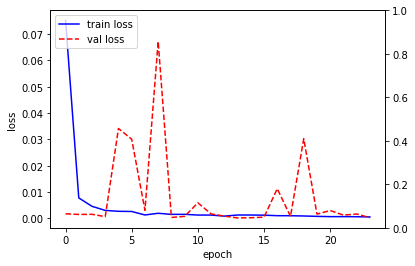

acc: 1.0000	loss: 0.0002
=============================================3 finished=============================================


In [12]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\MSU-MFSD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '3'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '3'
    
    saveDir = 'trained_model_public\\MSU-MFSD\\3'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\MSU-MFSD\\MSU-MFSD-3', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  4
=============================================ResNet-18==============================================
Found 24432 images belonging to 2 classes.
Found 8924 images belonging to 2 classes.
Epoch 1/100
1527/1527 [==============================] - 134s 88ms/step - loss: 0.0733 - acc: 0.9758 - val_loss: 0.3303 - val_acc: 0.9238

Epoch 00001: val_loss improved from inf to 0.33026, saving model to trained_model_public\MSU-MFSD\4\4-01-0.3303.hdf5
Epoch 2/100
1527/1527 [==============================] - 125s 82ms/step - loss: 0.0087 - acc: 0.9981 - val_loss: 0.1266 - val_acc: 0.9485

Epoch 00002: val_loss improved from 0.33026 to 0.12664, saving model to trained_model_public\MSU-MFSD\4\4-02-0.1266.hdf5
Epoch 3/100
1527/1527 [==============================] - 124s 82ms/step - loss: 0.0045 - acc: 0.9994 - val_loss: 0.2898 - val_acc: 0.9186

Epoch 00003: val_loss did not improve from 0.12664
Epoch 4/100
1527/1527 [==============================] - 124s 81ms/step - loss: 0.0034 - acc: 0.9994 -

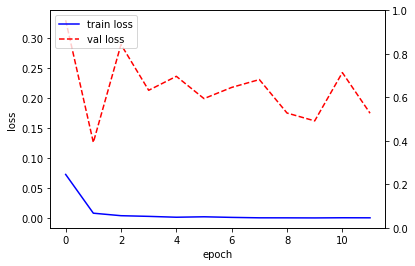

acc: 0.9485	loss: 0.1266
=============================================4 finished=============================================


In [13]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\MSU-MFSD\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '4'
    
    saveDir = 'trained_model_public\\MSU-MFSD\\4'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\MSU-MFSD\\MSU-MFSD-4', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# NUAA-PI

>>  1
=============================================ResNet-18==============================================
Found 2014 images belonging to 2 classes.
Found 966 images belonging to 2 classes.
Epoch 1/100
126/126 [==============================] - 13s 100ms/step - loss: 0.1279 - acc: 0.9697 - val_loss: 0.4600 - val_acc: 0.8582

Epoch 00001: val_loss improved from inf to 0.45995, saving model to trained_model_public\NUAA-PI\1\1-01-0.4600.hdf5
Epoch 2/100
126/126 [==============================] - 10s 81ms/step - loss: 0.0375 - acc: 0.9921 - val_loss: 0.5328 - val_acc: 0.8903

Epoch 00002: val_loss did not improve from 0.45995
Epoch 3/100
126/126 [==============================] - 10s 81ms/step - loss: 0.0341 - acc: 0.9901 - val_loss: 0.2734 - val_acc: 0.9006

Epoch 00003: val_loss improved from 0.45995 to 0.27344, saving model to trained_model_public\NUAA-PI\1\1-03-0.2734.hdf5
Epoch 4/100
126/126 [==============================] - 10s 81ms/step - loss: 0.0256 - acc: 0.9931 - val_loss: 0.25

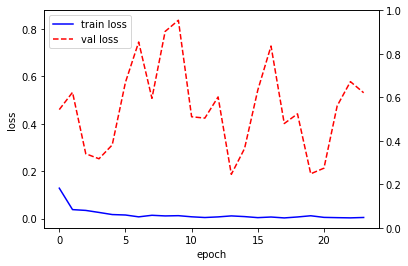

acc: 0.9079	loss: 0.1864
=============================================1 finished=============================================


In [14]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '1'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '1'
    
    saveDir = 'trained_model_public\\NUAA-PI\\1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\NUAA-PI\\NUAA-PI-1', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  2
=============================================ResNet-18==============================================
Found 2314 images belonging to 2 classes.
Found 666 images belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 13s 92ms/step - loss: 0.1518 - acc: 0.9543 - val_loss: 0.1001 - val_acc: 0.9790

Epoch 00001: val_loss improved from inf to 0.10012, saving model to trained_model_public\NUAA-PI\2\2-01-0.1001.hdf5
Epoch 2/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0442 - acc: 0.9914 - val_loss: 0.0455 - val_acc: 0.9955

Epoch 00002: val_loss improved from 0.10012 to 0.04551, saving model to trained_model_public\NUAA-PI\2\2-02-0.0455.hdf5
Epoch 3/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0365 - acc: 0.9914 - val_loss: 0.0474 - val_acc: 0.9970

Epoch 00003: val_loss did not improve from 0.04551
Epoch 4/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0260 - acc: 0.9944 - val_loss: 0.024

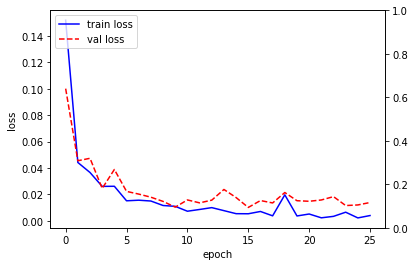

acc: 0.9985	loss: 0.0101
=============================================2 finished=============================================


In [15]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '2'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '2'
    
    saveDir = 'trained_model_public\\NUAA-PI\\2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\NUAA-PI\\NUAA-PI-2', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  3
=============================================ResNet-18==============================================
Found 2305 images belonging to 2 classes.
Found 675 images belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 13s 90ms/step - loss: 0.1356 - acc: 0.9672 - val_loss: 0.0600 - val_acc: 0.9941

Epoch 00001: val_loss improved from inf to 0.06001, saving model to trained_model_public\NUAA-PI\3\3-01-0.0600.hdf5
Epoch 2/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0364 - acc: 0.9940 - val_loss: 0.0726 - val_acc: 0.9852

Epoch 00002: val_loss did not improve from 0.06001
Epoch 3/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0332 - acc: 0.9871 - val_loss: 0.1124 - val_acc: 0.9378

Epoch 00003: val_loss did not improve from 0.06001
Epoch 4/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0236 - acc: 0.9884 - val_loss: 0.1150 - val_acc: 0.9215

Epoch 00004: val_loss did not improve from 0.060

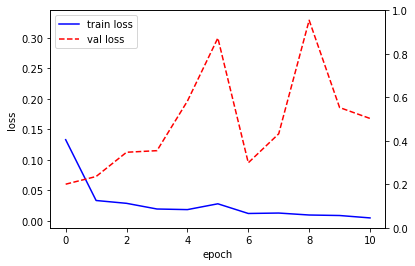

acc: 0.9941	loss: 0.0600
=============================================3 finished=============================================


In [16]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '3'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '3'
    
    saveDir = 'trained_model_public\\NUAA-PI\\3'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\NUAA-PI\\NUAA-PI-3', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  4
=============================================ResNet-18==============================================
Found 2307 images belonging to 2 classes.
Found 673 images belonging to 2 classes.
Epoch 1/100
145/145 [==============================] - 13s 91ms/step - loss: 0.1661 - acc: 0.9546 - val_loss: 0.0714 - val_acc: 0.9955

Epoch 00001: val_loss improved from inf to 0.07141, saving model to trained_model_public\NUAA-PI\4\4-01-0.0714.hdf5
Epoch 2/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0524 - acc: 0.9866 - val_loss: 0.0115 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.07141 to 0.01150, saving model to trained_model_public\NUAA-PI\4\4-02-0.0115.hdf5
Epoch 3/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0276 - acc: 0.9957 - val_loss: 0.0049 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.01150 to 0.00489, saving model to trained_model_public\NUAA-PI\4\4-03-0.0049.hdf5
Epoch 4/100
145/145 [=========================

145/145 [==============================] - 11s 77ms/step - loss: 0.0050 - acc: 0.9996 - val_loss: 9.8763e-04 - val_acc: 1.0000

Epoch 00040: val_loss did not improve from 0.00088
Epoch 41/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0025 - acc: 1.0000 - val_loss: 7.7161e-04 - val_acc: 1.0000

Epoch 00041: val_loss improved from 0.00088 to 0.00077, saving model to trained_model_public\NUAA-PI\4\4-41-0.0008.hdf5
Epoch 42/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0108 - acc: 0.9977 - val_loss: 0.0053 - val_acc: 1.0000

Epoch 00042: val_loss did not improve from 0.00077
Epoch 43/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0108 - acc: 0.9977 - val_loss: 0.0078 - val_acc: 1.0000

Epoch 00043: val_loss did not improve from 0.00077
Epoch 44/100
145/145 [==============================] - 11s 77ms/step - loss: 0.0160 - acc: 0.9973 - val_loss: 0.0434 - val_acc: 0.9807

Epoch 00044: val_loss did not improve from 0.00

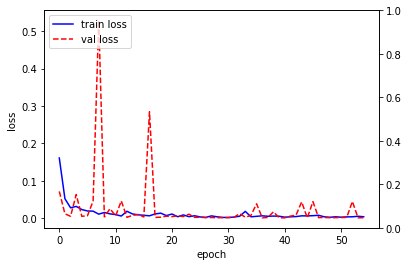

acc: 1.0000	loss: 0.0005
=============================================4 finished=============================================


In [17]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result\\NUAA-PI\\train'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = '4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = '4'
    
    saveDir = 'trained_model_public\\NUAA-PI\\4'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    
    np.save('trained_model_public\\NUAA-PI\\NUAA-PI-4', hist.history['val_loss'])
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))
    
    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# REPLAY-ATTACK

>>  REPLAY-ATTACK
=============================================ResNet-18==============================================
Found 91779 images belonging to 2 classes.
Found 90725 images belonging to 2 classes.
Epoch 1/100
5737/5737 [==============================] - 675s 118ms/step - loss: 0.0216 - acc: 0.9944 - val_loss: 0.0074 - val_acc: 0.9982

Epoch 00001: val_loss improved from inf to 0.00743, saving model to trained_model_public\REPLAY-ATTACK\REPLAY-ATTACK-01-0.0074.hdf5
Epoch 2/100
5737/5737 [==============================] - 670s 117ms/step - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9997

Epoch 00002: val_loss improved from 0.00743 to 0.00450, saving model to trained_model_public\REPLAY-ATTACK\REPLAY-ATTACK-02-0.0045.hdf5
Epoch 3/100
5737/5737 [==============================] - 686s 120ms/step - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0058 - val_acc: 0.9993

Epoch 00003: val_loss did not improve from 0.00450
Epoch 4/100
5737/5737 [==============================] -

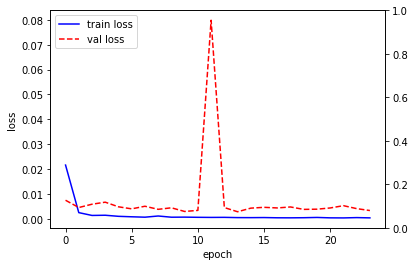

acc: 0.9997	loss: 0.0028
=======================================REPLAY-ATTACK finished=======================================


In [18]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\crop_result'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'REPLAY-ATTACK'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'REPLAY-ATTACK'
    
    saveDir = 'trained_model_public\\REPLAY-ATTACK'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()